In [1]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pyplot as plt
%matplotlib inline 

from tqdm import tqdm
tqdm.pandas(desc="progress-bar", mininterval=2)

from pdpbox import pdp


/home/abe/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/abe/.local/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


We will use Python pandas, numpy, xgboost and some modules within scikit-learn to digest this problem. XGBoost was chosen due to its good performance across a range of possible problem domains.

Before loading in the dataset, we use the VisiData program to quickly check what's inside the .CSV file and use the dtype option in pandas' read_csv method to cast the values of the data to those that optize free memory. It may not matte so much in this specific case, but it's a good practice in general, since datasets could be enormous and memory requirements could exceed available resources for a typical workstation unless the types are casted properly.  

In [10]:
data = pd.read_csv("conversion_data.csv", dtype={'country':str,
                                                'age': np.int8,
                                                'new_user': np.int8,
                                                'source': str,
                                                'total_pages_visited': np.int8,
                                                'convered': np.int8})

In [11]:
data.head()
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


Looks like everything was read properly, and fortunately, there's no missing values. There are a couple things to note right away. It seems that there are a couple of invalid age entries: one at 123 and one at 111. Perhaps users entered their birth year incorrectly, as it's unlikely that people that old are actually making purchases from the site. Since the data set is relatively large at 316k entries, it is entirely reasonable to either delete both of those entries, or replace them with the median value. Let's go with substituting for the median value. 

Next, we will want to plot some simple relationships as part of an exploratory analysis.

Additionally, we will need to encode the country and source information as numerics. Pandas has a super-convenient DataFrame method called get_dummies that we'll use for this. 

Finally, it looks like our total conversions are around 3.25%. The goal of the exercise is to report some ways to incresse this to the marketing team, so we need to keep that goal in mind. 

In [12]:
data.loc[data['age'] > 80, 'age'] = int(data.age.median())
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569307,0.685465,4.872966,0.032258
std,8.268932,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,79.000000,1.000000,29.000000,1.000000


Looks like we were succesful in cleaning up the age data. Next is doing some exploratory analysis. First let's make a table of the conversion rate and total site visits grouped by country:

In [13]:
data[['country', 'converted']].groupby(['country']).agg(['mean', 'count'])

converted        
             mean   count
country                  
China    0.001332   76602
Germany  0.062500   13056
UK       0.052632   48450
US       0.037801  178092

So Germany has the highest conversion rate, but the fewest customers. China's conversion rate is very low, and yet they have the second-most customers. Already we can tell that perhaps there's a problem for Chinese users of the site.

Next, let's look at age and plot the results (since there's far more possible values of ages than countries).

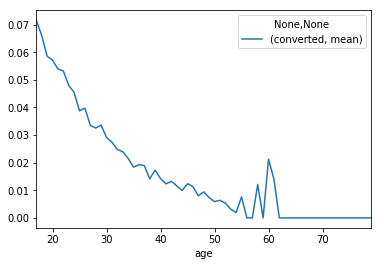

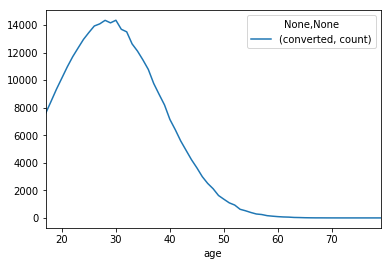

In [14]:
data[['age', 'converted']].groupby(['age']).agg(['mean']).plot()
data[['age', 'converted']].groupby(['age']).agg(['count']).plot()

It looks like younger users will tend to buy more frequently and the conversion rate decreases nearly monotonically with age, but the peak of the distribution of site visitors occurs around ~30 years. 

Lastly, let's look at total pages visited.

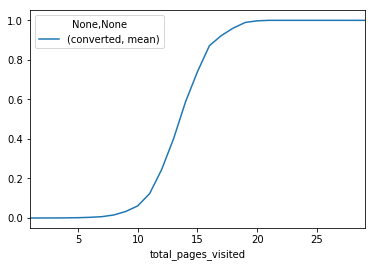

In [15]:
data[['total_pages_visited', 'converted']].groupby(['total_pages_visited']).agg(['mean']).plot()

Here we see a very clear trend that the more time a user spends on a site, the more likely they are to buy something. The inflection point is about ~15 pages.

Onto the vectoriztion of features part in preparation for model building. We just want to get dummy features and save as a new copy of the data DataFrame.

In [16]:
data = pd.get_dummies(data)
data.head()

,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,0,1,0,1,0,0
1,23,1,5,0,0,0,0,1,0,0,1
2,28,1,4,0,0,0,0,1,0,0,1
3,39,1,5,0,1,0,0,0,0,0,1
4,30,1,6,0,0,0,0,1,0,0,1


Awesome! Now we're finished doing exploratory analysis and cleaning the dataset. Our next job will be to split the data into four training and testing sets using k-fold cross validation ater we split into X (features) and Y (targets). Additionally, now's the time to convert the pandas dataframe into numpy array which the XGBoost classifier will use. 

In [40]:
X = data.drop("converted", axis=1).values
Y = data["converted"].values
kf = KFold(n_splits=4, shuffle=True, random_state=666)

In [41]:
acc_results = []
imp_results = []
conf_matrix = np.matrix([[0,0],[0,0]])
model = XGBClassifier()
# "Error_function" can be replaced by the error function of your analysis
for traincv, testcv in kf.split(X):
        probas = model.fit(X[traincv], Y[traincv]).predict(X[testcv])
        acc_results.append( accuracy_score(Y[testcv], probas) )
        imp_results.append( model.feature_importances_.tolist())
        conf_matrix = conf_matrix + np.matrix(confusion_matrix(Y[testcv], probas))
        
print("Accuracy results: " + str( np.array(acc_results).mean() ) )


Accuracy results: 0.986040480708


We have created and fitted a series of five XGBoost models with default parameters, each corresponding to a random 80:20 test:train split. The overall accuracy in predicting conversions is 98.6%. In the process, we have also extracted feature importance vectors for each cross-validation trial. To average them across a list of lists, we use the following trick: 

In [42]:
from statistics import mean
avg_importance = [*map(mean, zip(*imp_results))]
# features = data.drop("converted", axis=1).columns.values

Let's view the confusion matrix

In [43]:
print(conf_matrix)

[[304800   1200]
 [  3214   6986]]


Now, visualize the relative importances for each feature on the target. Keep in mind that this model is preliminary; i.e. we would ideally like to create a more fine-grained model and optimize parameters in a moment.

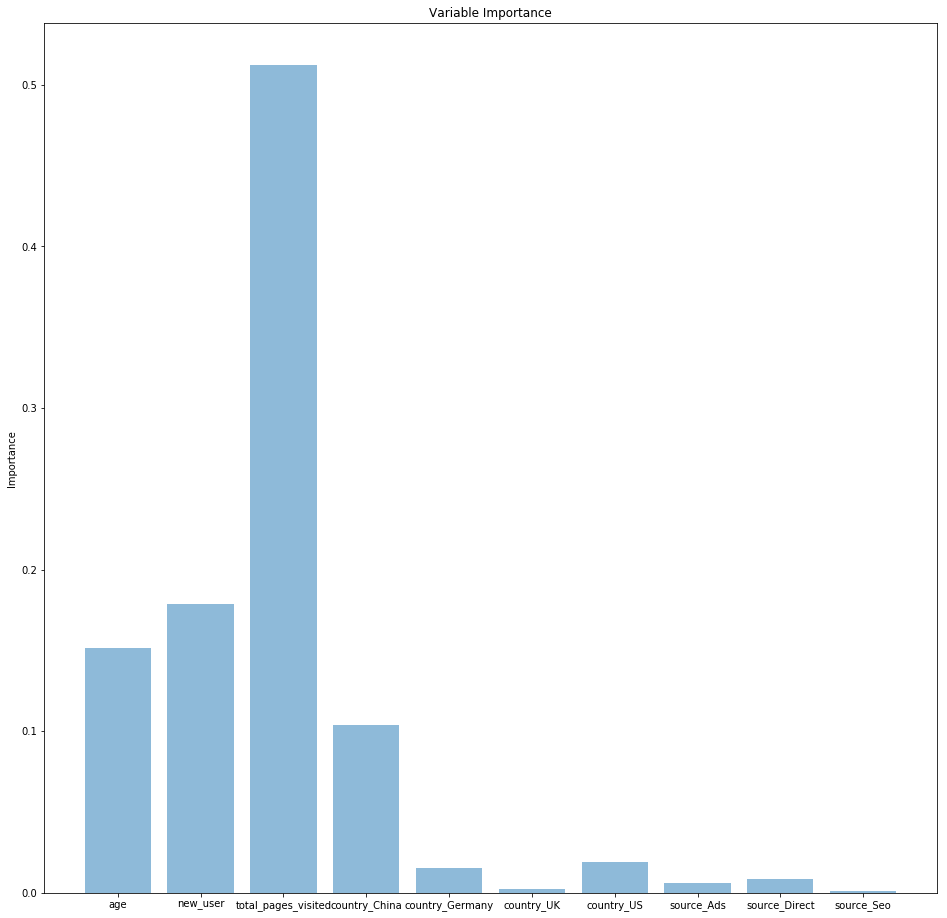

In [44]:
width = 16
height = 16
plt.figure(figsize=(width, height))

x_pos = range(1, len(avg_importance)+1)
plt.bar(x_pos, avg_importance, align='center', alpha=0.5)
plt.ylabel('Importance')
plt.xticks(x_pos, features)
plt.title('Variable Importance')
 
plt.show()

So, total_pages_visited seems to be the most important in predicting conversions. Sources, as a whole, seem to be the least important. The first four features in our DataFrame have much higher importance than the rest. However, the number of pages visited by a user, despite being the highest predictor of conversions, is probably the feature that we have the least control over from a site perspective. 

Let's take a closer look by building the model again without cross-validation and also without the total_pages_visited feature, and by calling xgboost in a slightly different way. We'll also use PDPbox to sort through the partial dependence plots.

In [46]:
train = data.drop(["total_pages_visited"], axis=1)
y = data.converted.values
target = 'converted'
IDcol = 'ID'
train, test = train_test_split(train, test_size = 0.25)
# bst_cv = xgb.cv(params, Y, 500, nfold=5, early_stopping_rounds=10)

In [47]:
def modelfit(alg, dtrain, predictors, target, useTrainCV=True, cv_folds=4, early_stopping_rounds=50):
    """from:
    https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/"""
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(dtrain[target], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    return dtrain[target].values, dtrain_predictions


Model Report
Accuracy : 0.9676
AUC Score (Train): 0.819758


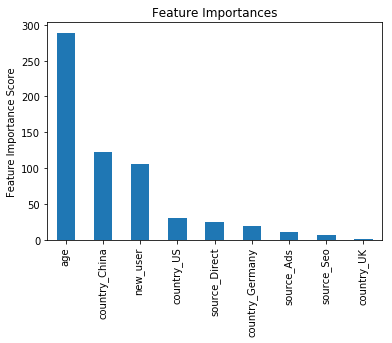

In [52]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
"""params = {learning_rate=0.05,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.75,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=69}"""
xgb1 = XGBClassifier()
dtrain_target, dtrain_predictions = modelfit(xgb1, train, predictors, target, useTrainCV=False)

So without the total_pages_visited feature, we reduce the accuracy from ~98.5% to ~96.8%. Keeping in mind that the overall conversion rate is still around 3.2%, this isn't so bad, but remember that the purpose here is to see the relative effect of the rest of the features. Nothing else is really surprising here, the variable importances look a lot like the earlier plot with the total_pages_visited feature removed, and the relative importance of age and new_user switched.

Let's make a function that we can call to sample the predictions made by an XGBoost instance and show the partial dependency of the target on each feature, to know in which direction the conversion prediction moves.

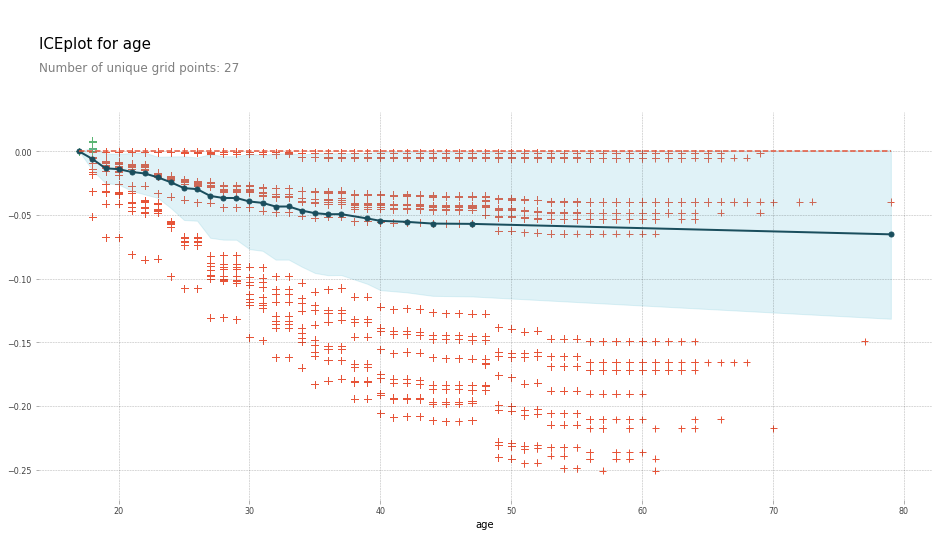

In [72]:
features = train.drop(["converted"], axis=1).columns
pdp_age = pdp.pdp_isolate(xgb1, data[features], 'age', num_grid_points=30)
pdp.pdp_plot(pdp_age, 'age', plot_org_pts=True)

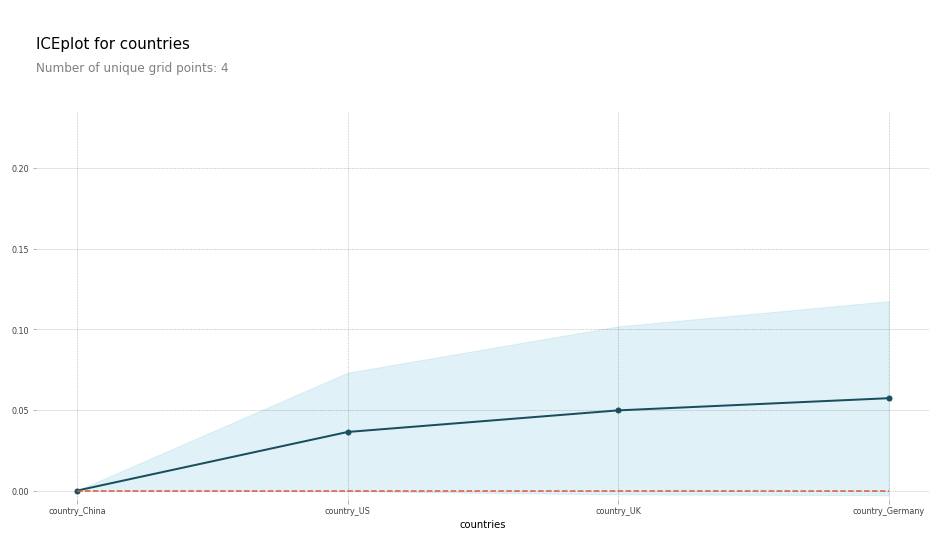

In [64]:
pdp_countries = pdp.pdp_isolate(xgb1, data[features], ['country_China', 'country_US', 
                                                       'country_UK', 'country_Germany'])
pdp.pdp_plot(pdp_countries, 'countries')

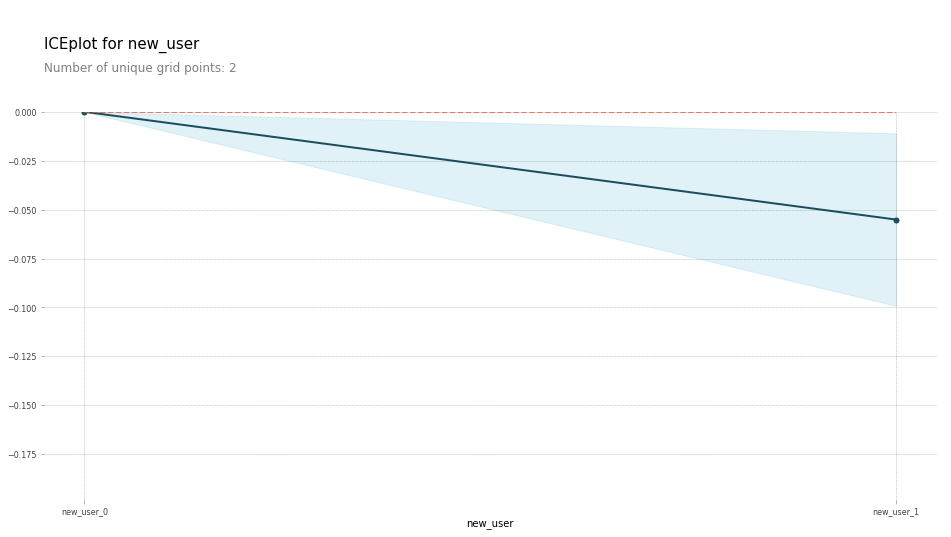

In [62]:
pdp_new_user = pdp.pdp_isolate(xgb1, data[features], 'new_user')
pdp.pdp_plot(pdp_new_user, 'new_user')

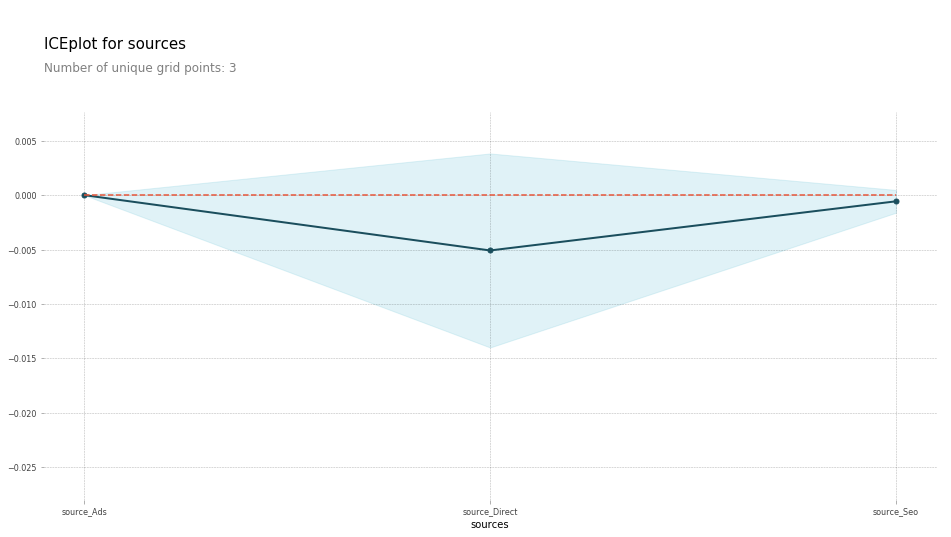

In [66]:
pdp_sources = pdp.pdp_isolate(xgb1, data[features], ['source_Ads', 'source_Direct','source_Seo'])
pdp.pdp_plot(pdp_sources, 'sources')